# Student Retention Predictor - Train Model
> Predicting college dropout risk using U.S. Department of Education data

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

/Users/sebastianjohannessen/Desktop/student-retention-predictor/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Preview Data

In [2]:
df = pd.read_csv('../data/college_scorecard_apr2025.csv', low_memory=False)
df.shape
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## Column Selection and Cleaning

In [3]:
cols = [
    'PCTPELL',         # Percentage of undergraduates who receive a Pell Grant
    'ADM_RATE',        # Admission rate
    'REGION',          # Region (IPEDS)
    'LOCALE',          # Locale of institution
    'RET_FT4'          # Target variable: First-time, full-time student retention rate at four-year institutions
]

# region 0: U.S. Service Schools
# region 1: New England (CT, ME, MA, NH, RI, VT)
# region 2: Mid East (DE, DC, MD, NJ, NY, PA)
# region 3: Great Lakes (IL, IN, MI, OH, WI)
# region 4: Plains (IA, KS, MN, MO, NE, ND, SD)
# region 5: Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC, TN, VA, WV)
# region 6: Southwest (AZ, NM, OK, TX)
# region 7: Rocky Mountains (CO, ID, MT, UT, WY)
# region 8: Far West (AK, CA, HI, NV, OR, WA)
# region 9: Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)

# Select relevant columns and drop rows with NaN values
df = df[cols].dropna()
# Keep only rows where REGION is between 1 and 8
df = df[(df['REGION'] >= 1) & (df['REGION'] <= 8)]

## Create Binary Target

In [4]:
# if retention rate is above 0.85, it is a success
# otherwise, it is a failure
df['TARGET'] = (df['RET_FT4'] > 0.85).astype(int)

## Convert Categorical Data

In [5]:
# group LOCALE values into broader categories
def simplify_locale(val):
    if val in [11, 12, 13]:
        return 'City'
    elif val in [21, 22, 23]:
        return 'Suburb'
    elif val in [31, 32, 33]:
        return 'Town'
    elif val in [41, 42, 43]:
        return 'Rural'
    else:
        return 'Unknown'
    
# apply the function to the LOCALE column
df['LOCALE_GROUPED'] = df['LOCALE'].apply(simplify_locale)

## Feature/Target Split

In [6]:
# One-hot encode REGION and LOCALE_GROUPED
df = pd.get_dummies(df, columns=['REGION', 'LOCALE_GROUPED'])

# Drop columns not used as features, including the old LOCALE column
X = df.drop(columns=['RET_FT4', 'TARGET', 'LOCALE'])
y = df['TARGET']

## Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Training and Exporting the Model

In [8]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

joblib.dump(rf, '../models/model.pkl')

['../models/model.pkl']

## Predict Using the Model

In [9]:
y_pred = rf.predict(X_test)

## Evaluate Performance

In [10]:
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       234
           1       0.85      0.55      0.67        92

    accuracy                           0.85       326
   macro avg       0.85      0.76      0.79       326
weighted avg       0.85      0.85      0.84       326

ROC AUC Score: 0.8700297287253809


## Explanation with SHAP

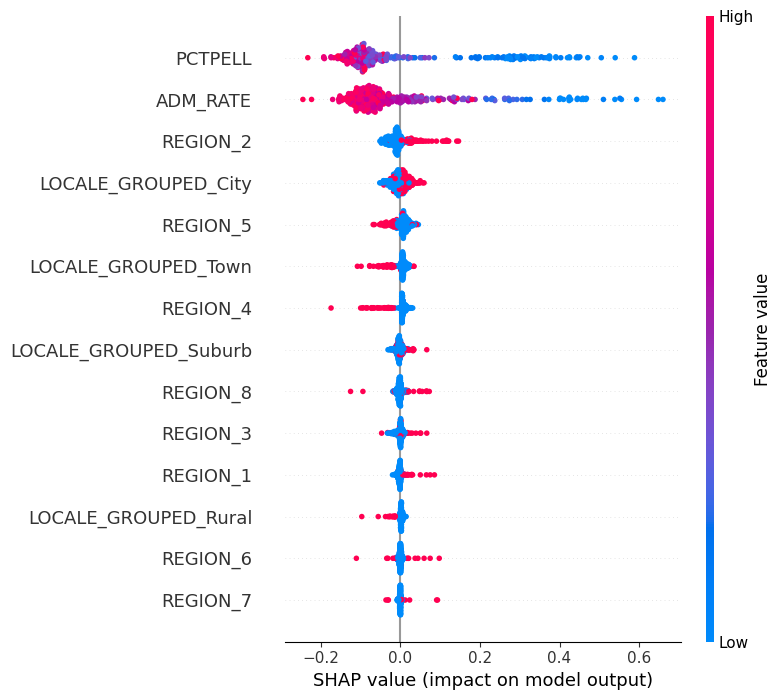

In [11]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test)

shap_values_class1 = shap_values[:, :, 1]  # Get values for class 1
shap.summary_plot(shap_values_class1, X_test)
